In [25]:
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
import types 
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 10
config.filter = np.array([0.1, 0.2, 0.3, 0.15, -0.05, -0.15, -0.2, -0.10, -0.05, 0.0])

In [3]:
config.filter.sum()

0.2

In [4]:
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

In [5]:
val_generator_baseline = get_dataset(dataset_dir, 
                                     'validation', 
                                     config.batch_size, 
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


2023-05-24 14:26:33.875628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 730, pci bus id: 0000:65:00.0, compute capability: 3.5) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-05-24 14:26:34.295465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10247 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1


In [6]:
for ii,(images,labels) in enumerate(val_generator_baseline):
    if ii==0:
        break

2023-05-24 14:26:36.148912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


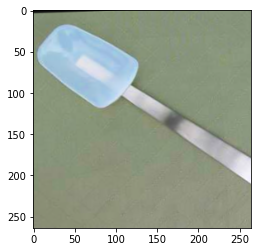

In [7]:
plt.imshow(images[0].numpy())

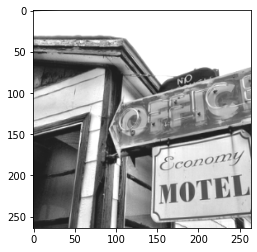

In [15]:
plt.imshow(images[3].numpy())

In [8]:
env = RetinaEnv(config)

In [9]:
env.reset(images)

In [10]:
coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += np.random.randint(-2,3,(config.batch_size,2))
    env.step(origins_offset+coordinates)
    print(env.images_history.shape)
    print(env.retinal_view.shape)

(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)
(32, 224, 224, 10)
(32, 224, 224, 1)


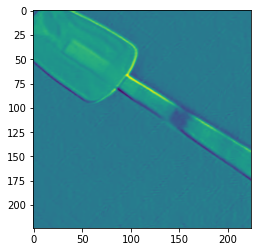

In [18]:
plt.imshow(env.retinal_view[0].numpy())

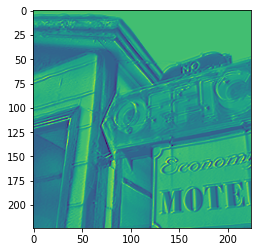

In [17]:
plt.imshow(env.retinal_view[3].numpy())

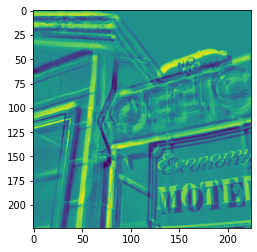

In [22]:
plt.imshow(env.images_history[3][:,:,0].numpy()-env.images_history[3][:,:,-1].numpy())

In [56]:
def spectral_power(images, convert_to_grayscale=False):
    #convert images to grayscale
    if convert_to_grayscale:
        images = rgb2gray(images)
    #squeeze singular dimensions
    images = np.squeeze(images)
    #compute fft
    fft = np.fft.fft2(images)
    #compute power spectra  
    power = np.abs(fft)**2
    #compute power spectra along horizontal axis
    power_h = np.sum(power,axis=1)
    #compute power spectra along vertical axis
    power_v = np.sum(power,axis=2)
    #sum power spectra along both directions
    power_sum = power_h + power_v
    return power_sum

#function that returns first half of power spectra
#images is a batch of images
#convert_to_grayscale is a boolean that indicates whether to convert images to grayscale
#returns a batch of 1D power spectra
def spectral_power_half(images, convert_to_grayscale=False):
    power = spectral_power(images, convert_to_grayscale)
    power_half = power[:,:power.shape[1]//2]
    return power_half

In [57]:
np.squeeze(env.images).shape

(32, 264, 264)

In [58]:
orig_spectrum = spectral_power_half(env.images)
retinal_spectrum = spectral_power_half(env.retinal_view)

In [59]:
orig_spectrum.shape

(32, 132)

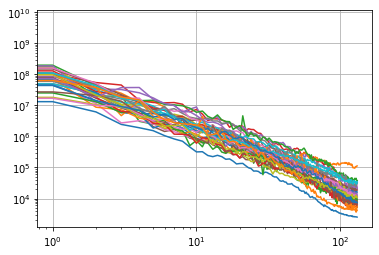

In [63]:
for spectrum in np.squeeze(orig_spectrum):
    plt.loglog(spectrum)
plt.grid()

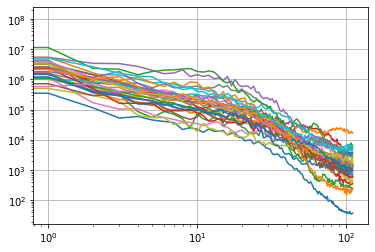

In [62]:
for spectrum in np.squeeze(retinal_spectrum):
    plt.loglog(spectrum)
plt.grid()

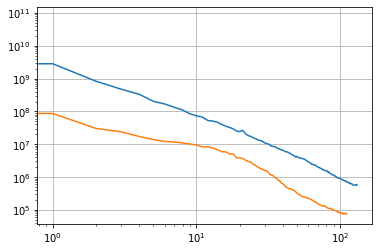

In [66]:
plt.loglog(orig_spectrum.sum(axis=0))
plt.loglog(retinal_spectrum.sum(axis=0))
plt.grid()

In [68]:
def calculate_retinal_filter(t, T1=5, T2=15, n=3, R=0.8):
    # Filter calculation
    t_filter = (t ** n / T1 ** (n + 1)) * np.exp(-t / T1) - R * (t ** n / T2 ** (n + 1)) * np.exp(-t / T2)
    t_filter = t_filter / np.max(t_filter)
    return t_filter

In [71]:
t_vec = np.linspace(0,150,16)
default_filter = calculate_retinal_filter(t_vec)

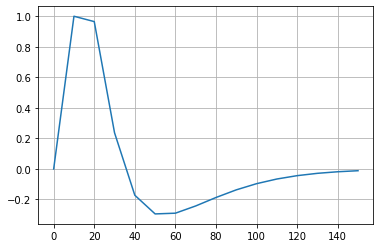

In [73]:
plt.plot(t_vec,default_filter)
plt.grid()

In [75]:
default_filter.sum(), np.abs(default_filter).sum()

(0.6137037081788854, 3.789630839210814)

In [81]:
env.filter = default_filter.reshape([1,1,-1,1])
env.config.history_length = 16

In [82]:
env.reset(images)

In [90]:
coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += np.random.randint(-2,3,(config.batch_size,2))
    env.step(origins_offset+coordinates)

In [91]:
orig_spectrum = spectral_power_half(env.images)
retinal_spectrum = spectral_power_half(env.retinal_view)

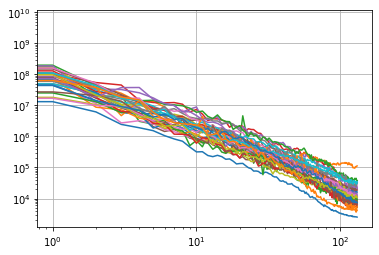

In [93]:
for spectrum in np.squeeze(orig_spectrum):
    _=plt.loglog(spectrum)
plt.grid()

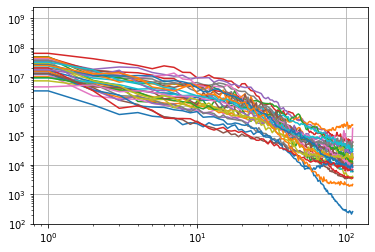

In [94]:
for spectrum in np.squeeze(retinal_spectrum):
    plt.loglog(spectrum)
plt.grid()

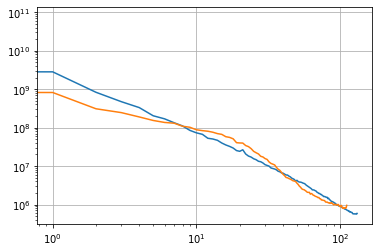

In [95]:
plt.loglog(orig_spectrum.sum(axis=0))
plt.loglog(retinal_spectrum.sum(axis=0))
plt.grid()

In [98]:
balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
env.filter = balanced_filter.reshape([1,1,-1,1])


In [99]:
env.reset(images)

In [100]:
coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += np.random.randint(-2,3,(config.batch_size,2))
    env.step(origins_offset+coordinates)

In [101]:
orig_spectrum = spectral_power_half(env.images)
retinal_spectrum = spectral_power_half(env.retinal_view)

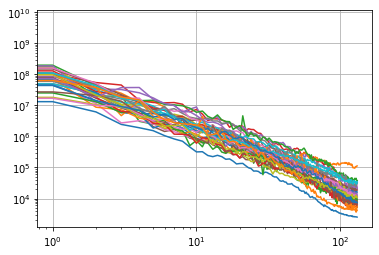

In [102]:
for spectrum in np.squeeze(orig_spectrum):
    _=plt.loglog(spectrum)
plt.grid()

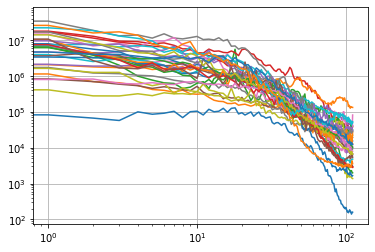

In [103]:
for spectrum in np.squeeze(retinal_spectrum):
    plt.loglog(spectrum)
plt.grid()

Text(0, 0.5, 'instantaneous spectral power [au]')

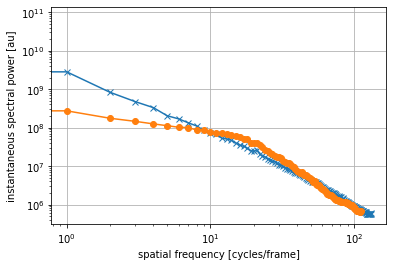

In [120]:
plt.loglog(orig_spectrum.sum(axis=0),'x-')
plt.loglog(retinal_spectrum.sum(axis=0),'o-')
plt.grid()
plt.xlabel('spatial frequency [cycles/frame]')
plt.ylabel('instantaneous spectral power [au]')

/tmp/ipykernel_9955/1739326699.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[15,8])


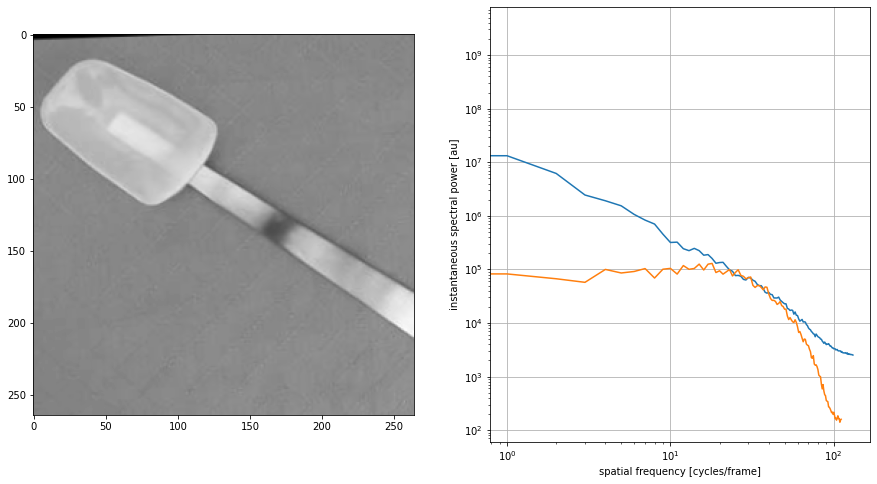

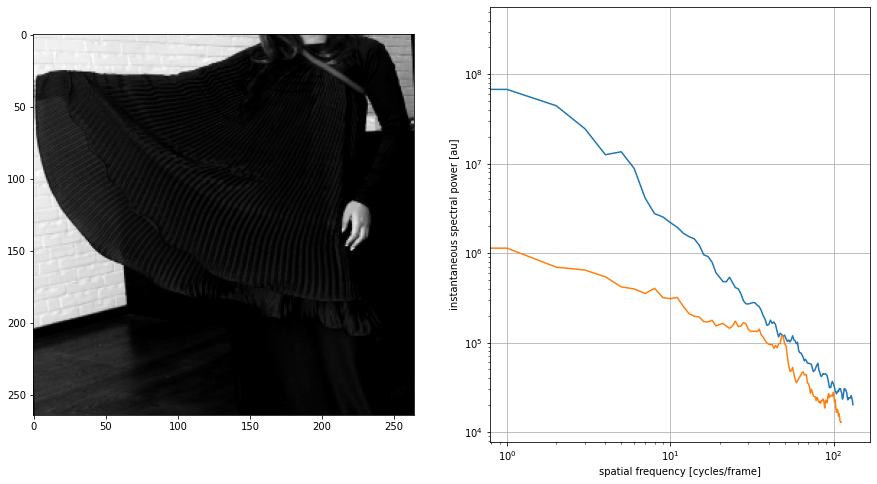

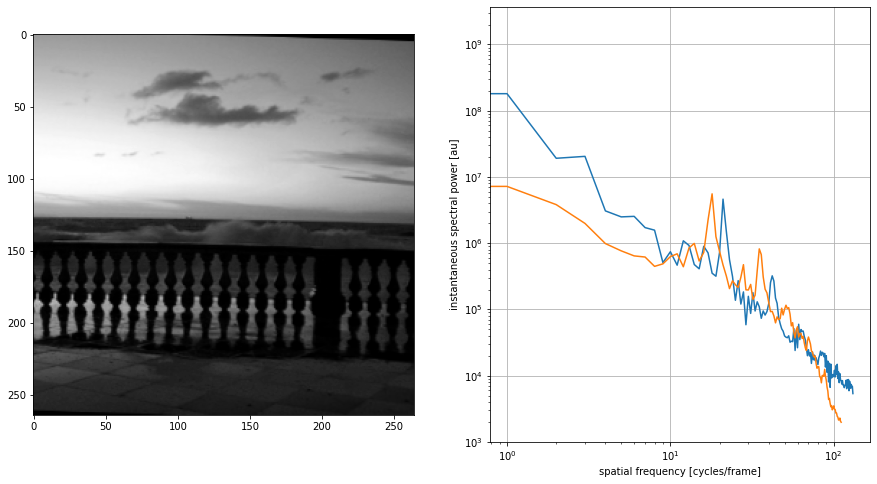

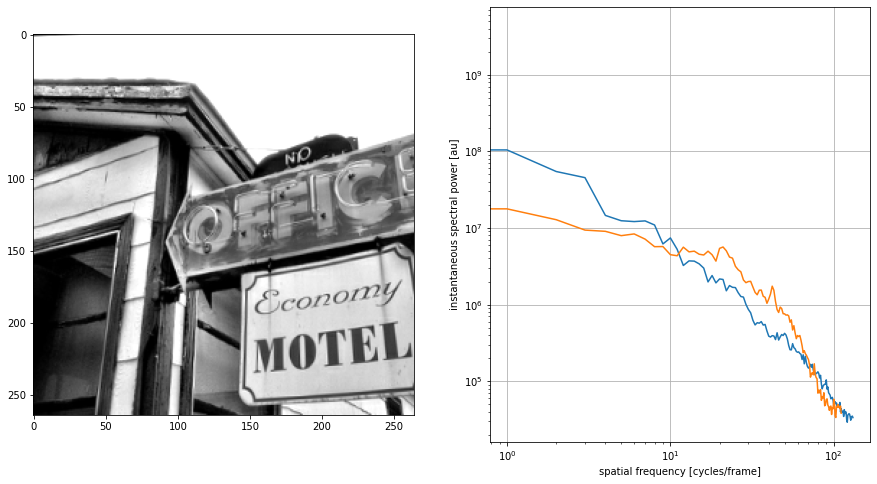

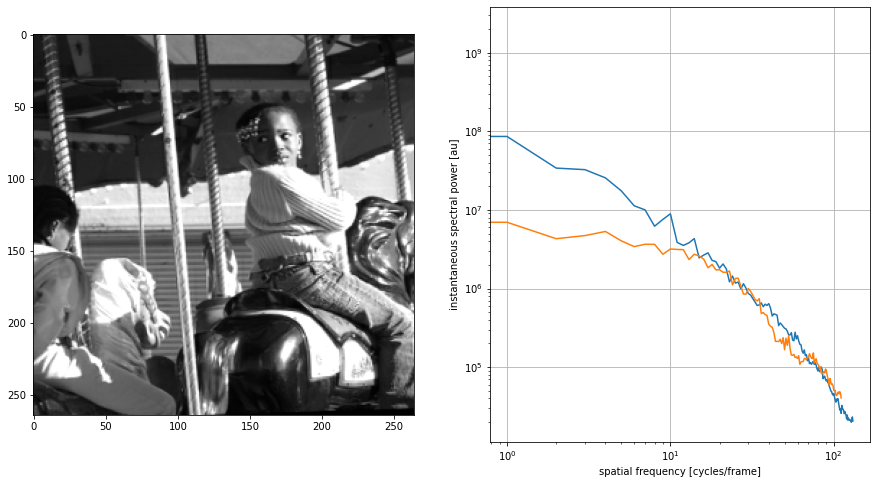

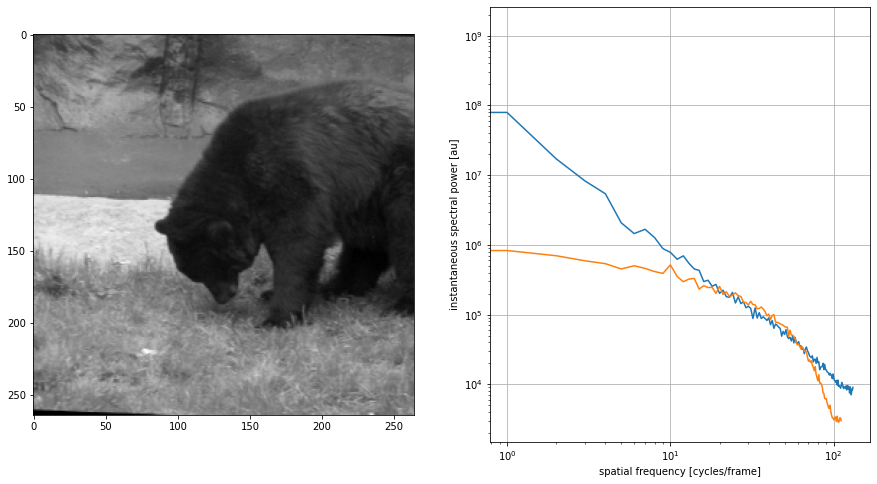

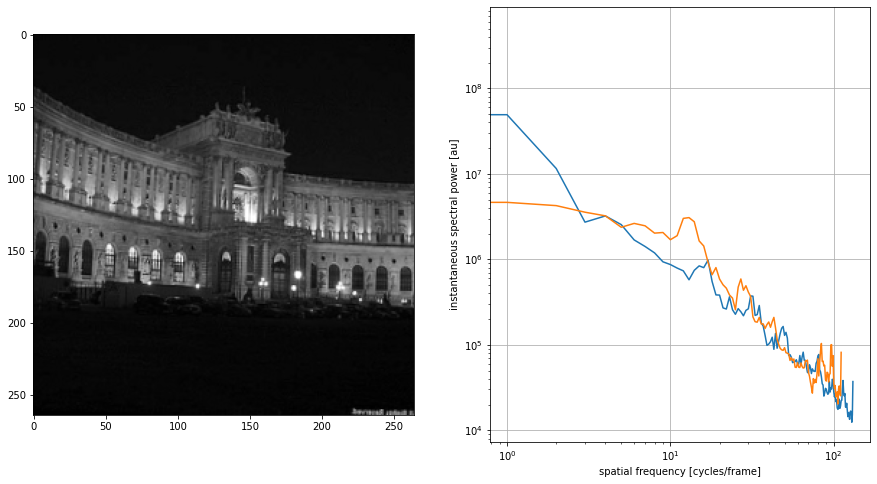

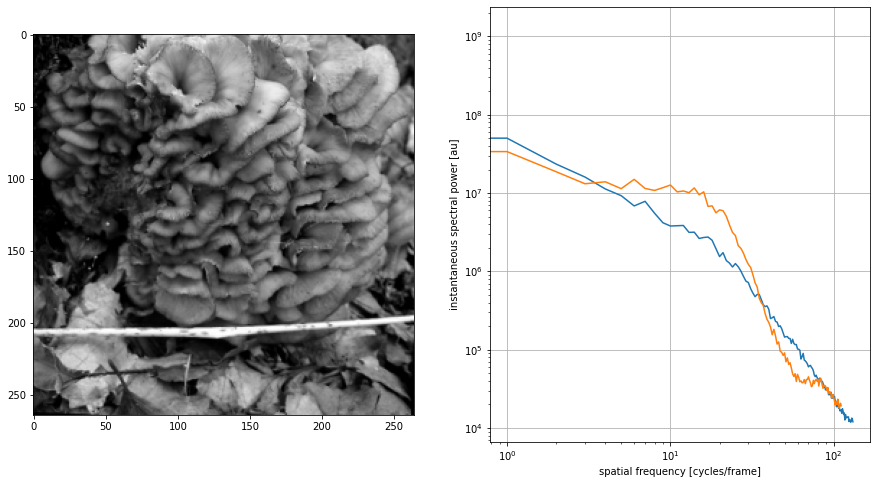

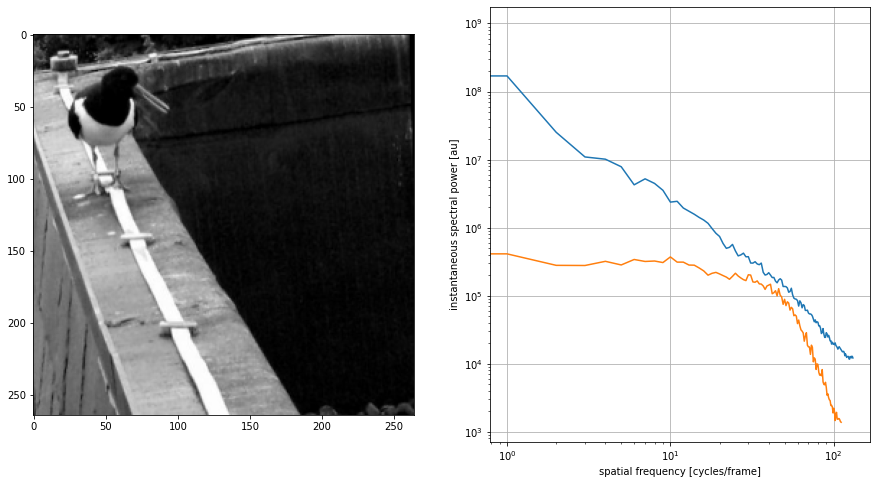

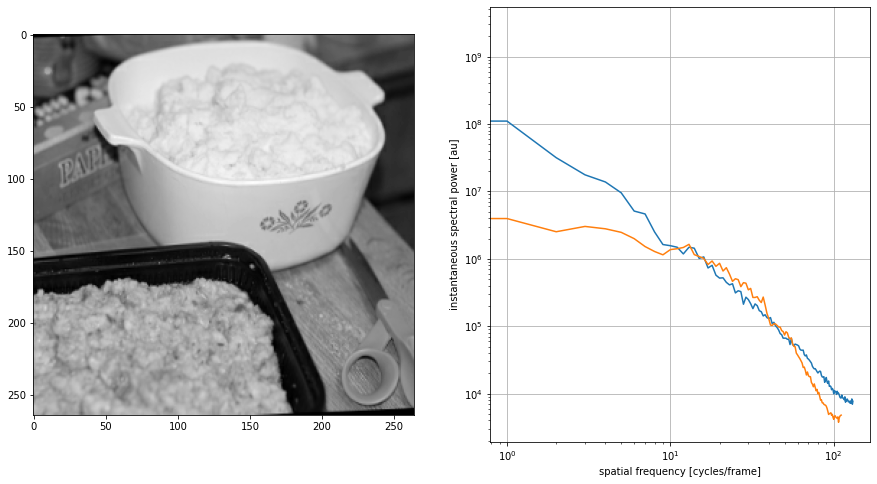

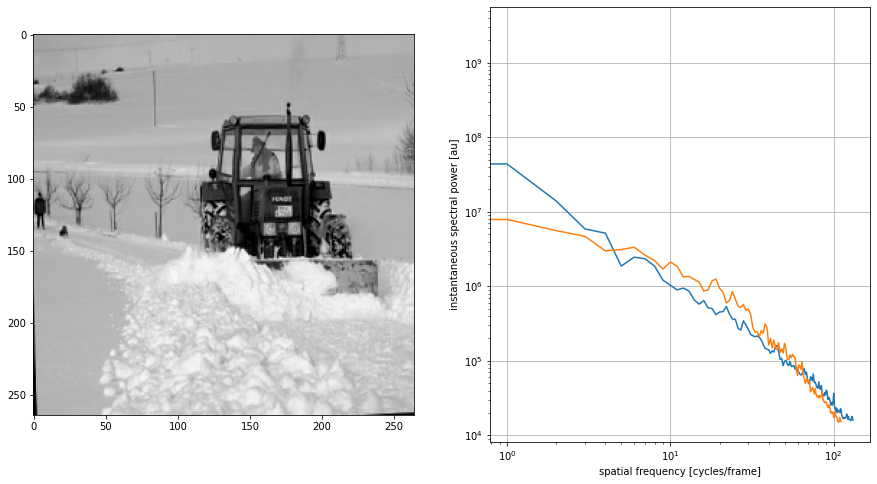

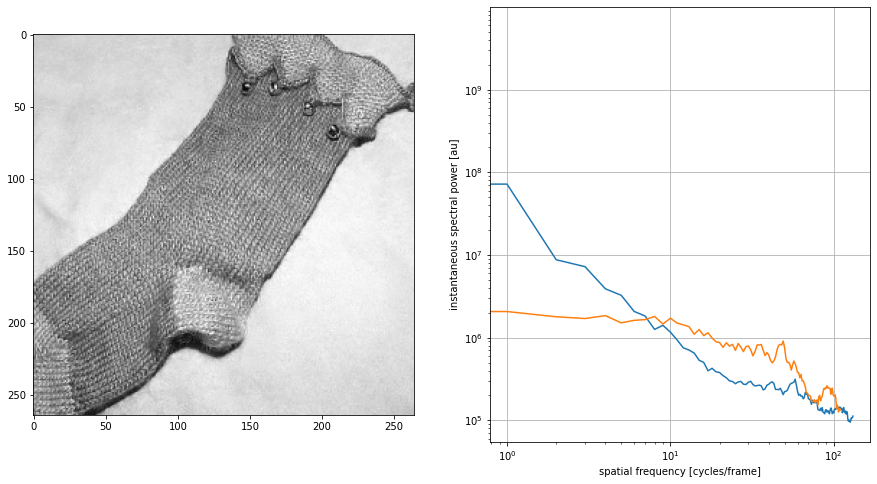

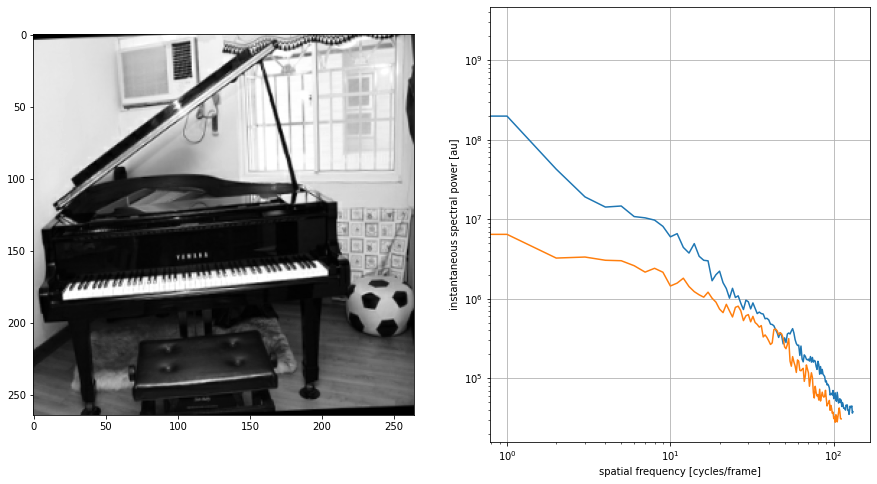

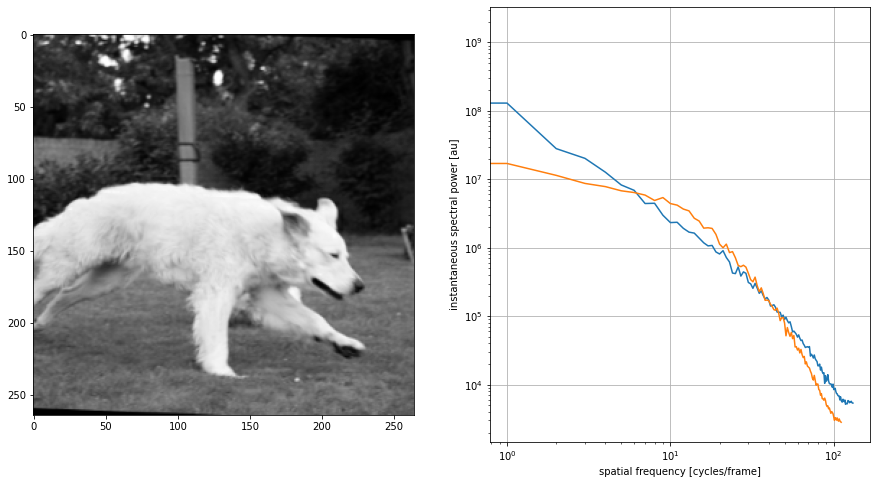

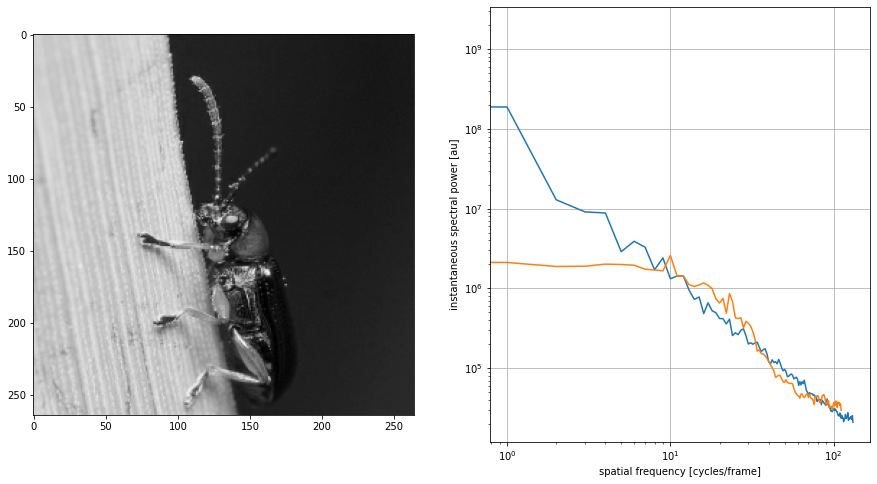

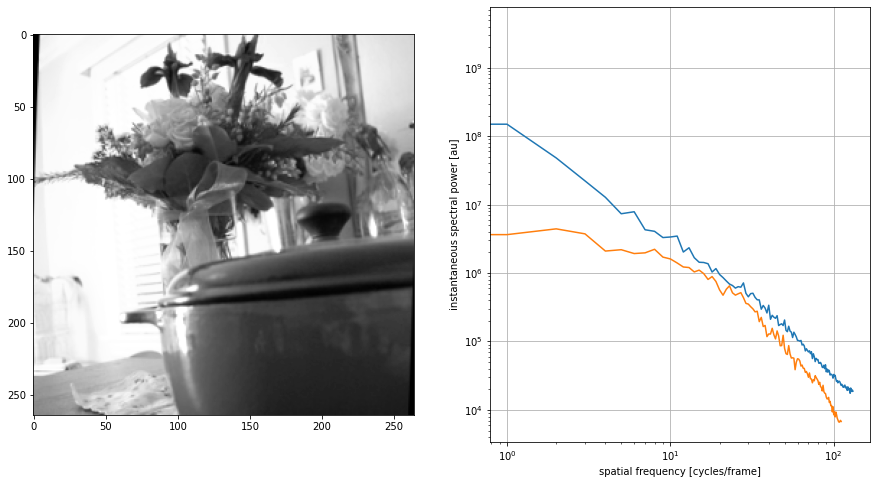

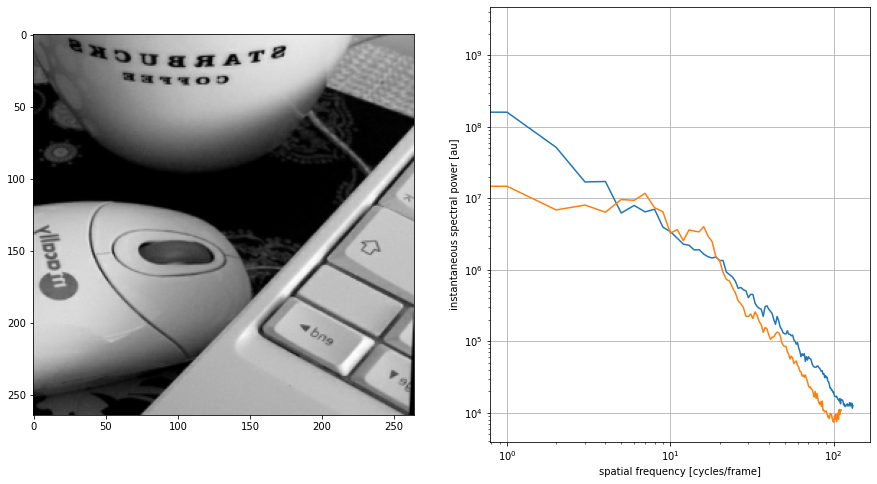

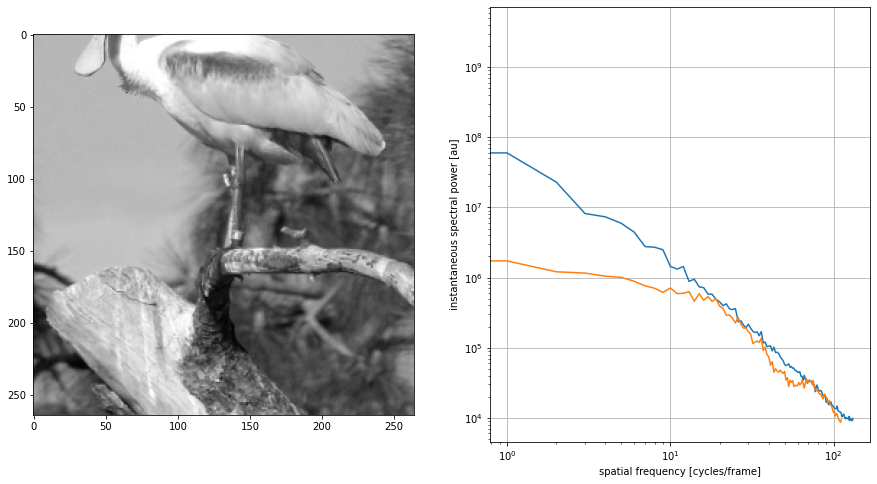

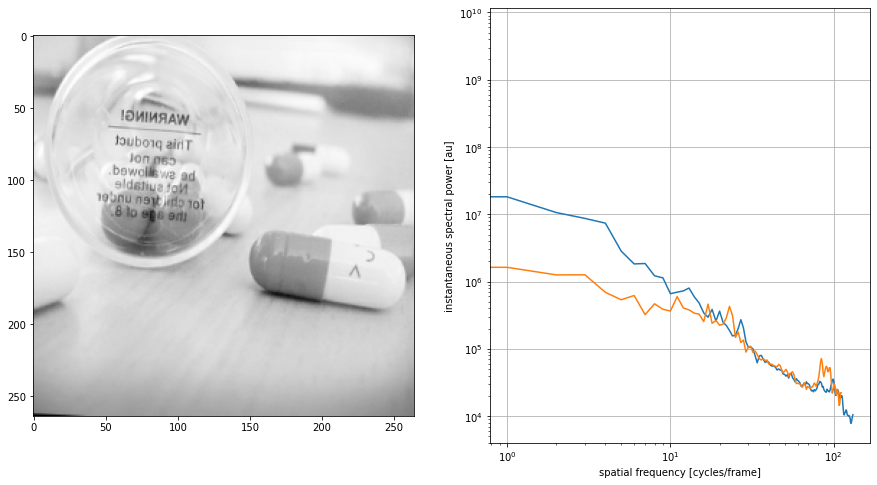

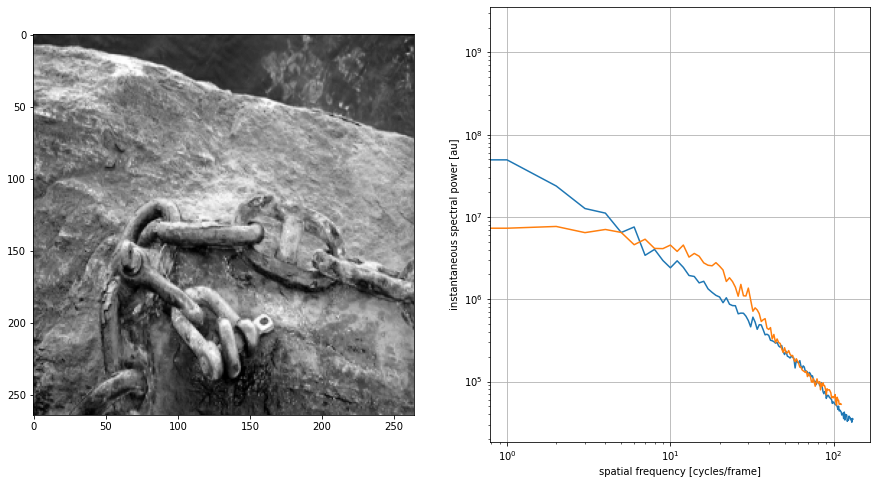

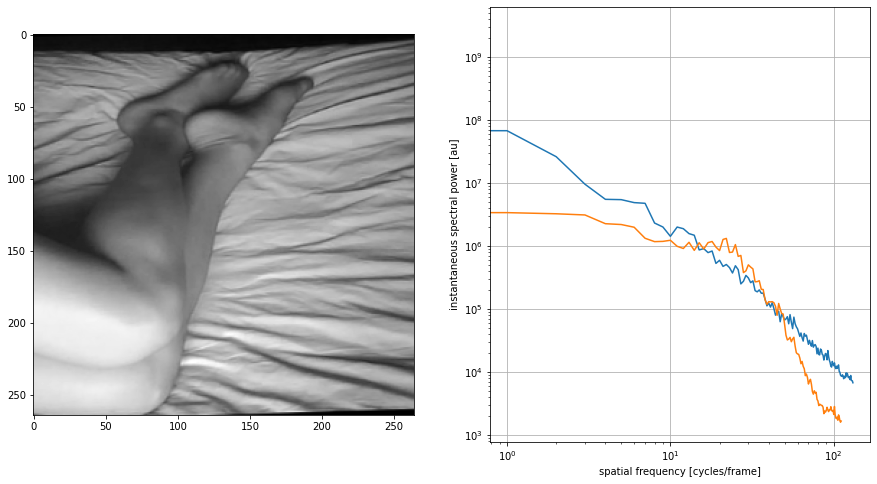

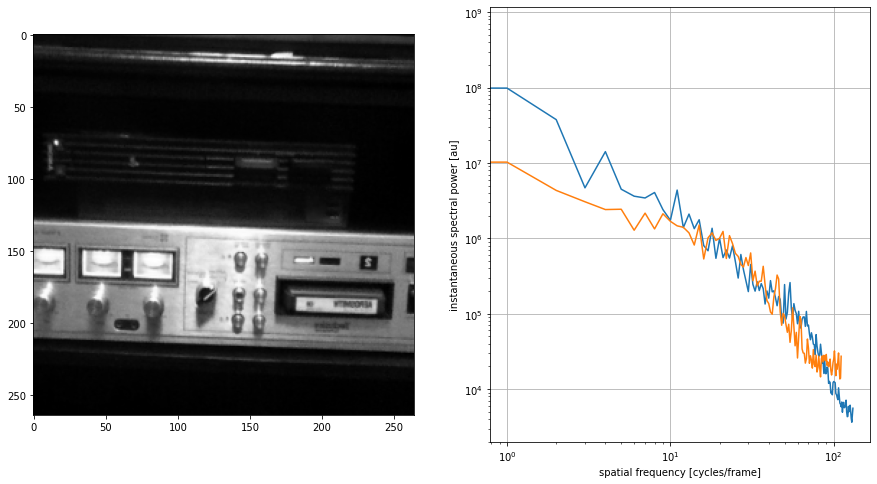

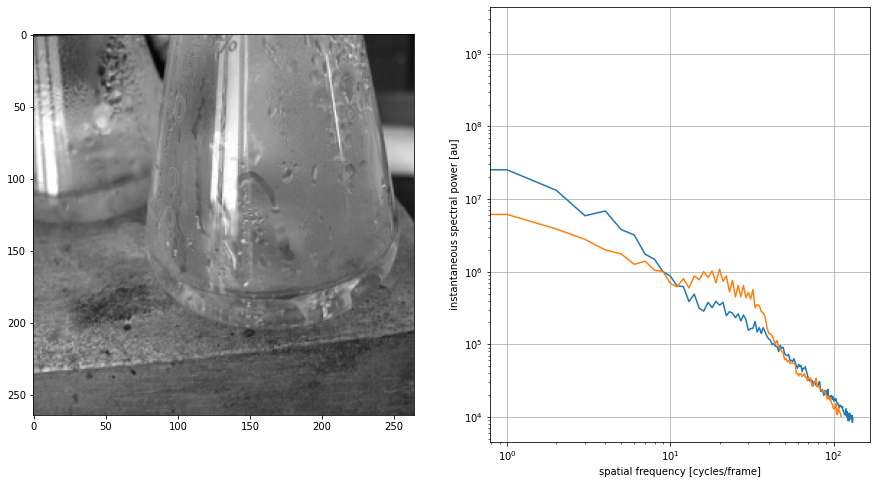

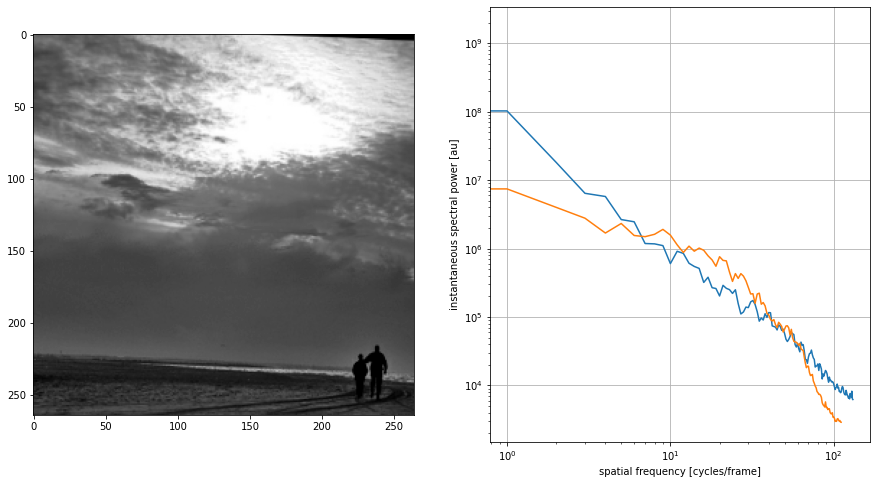

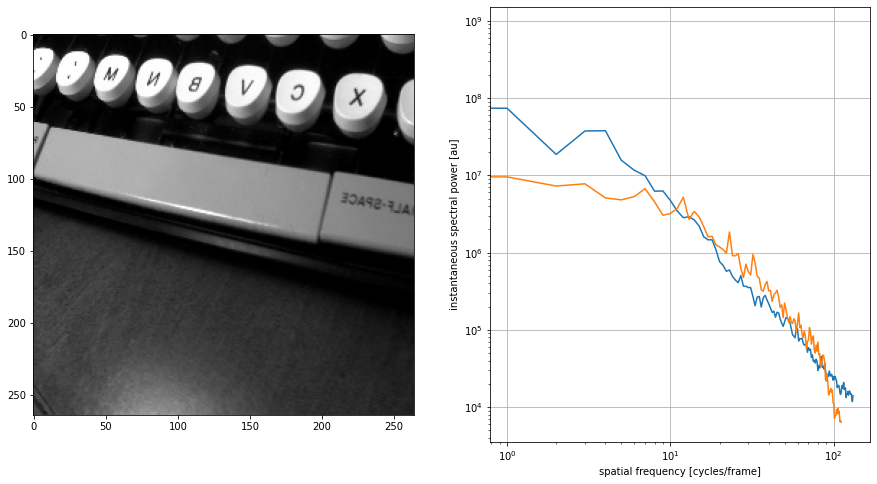

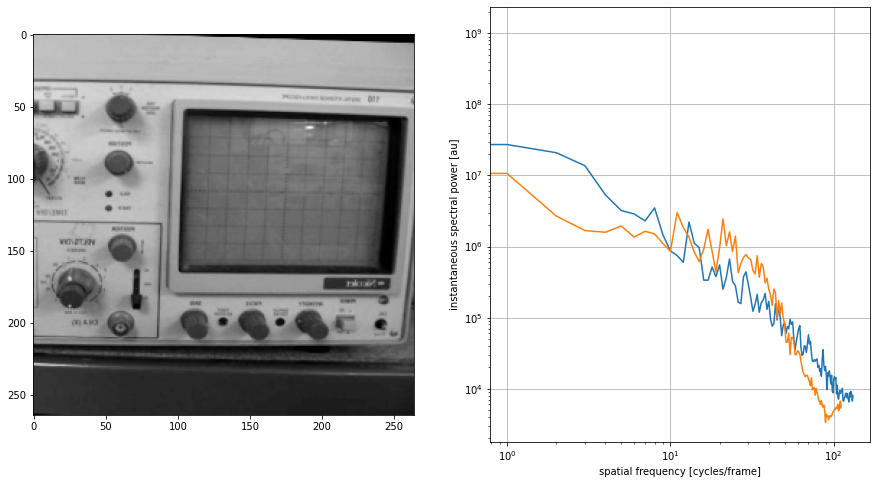

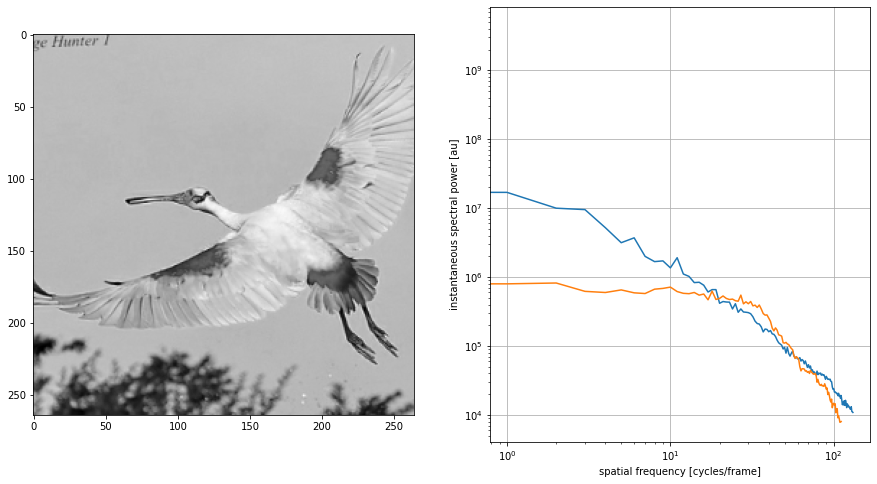

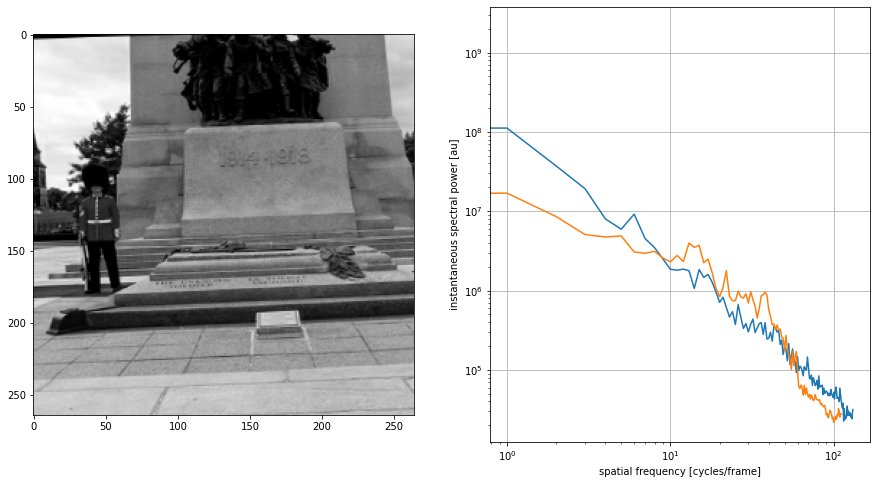

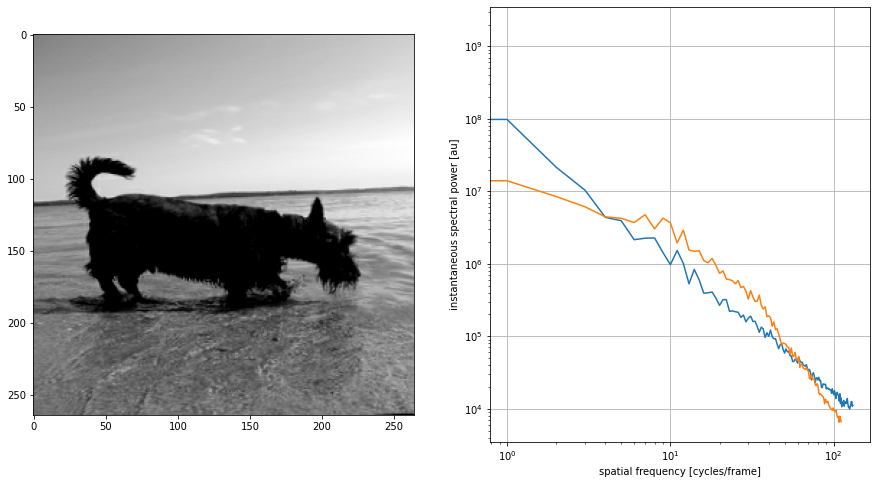

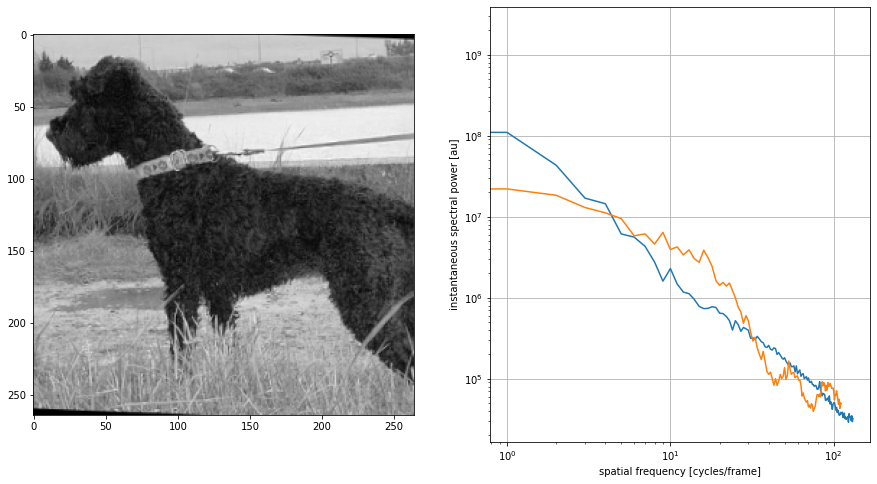

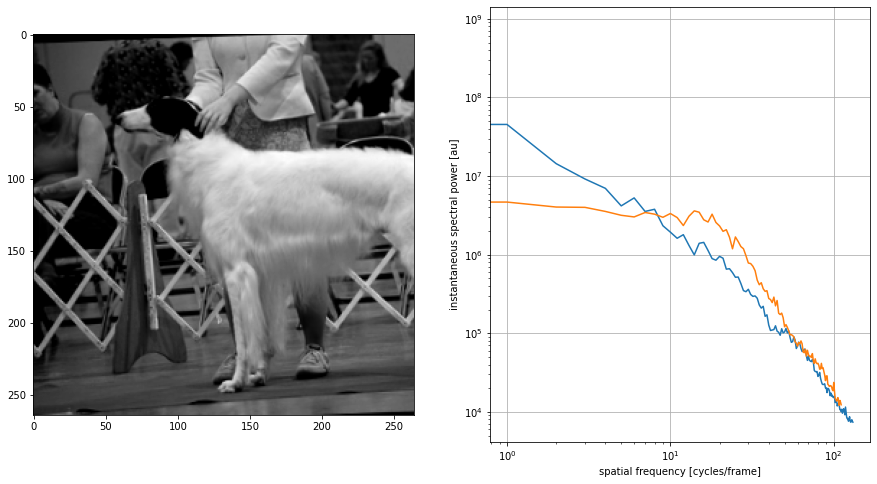

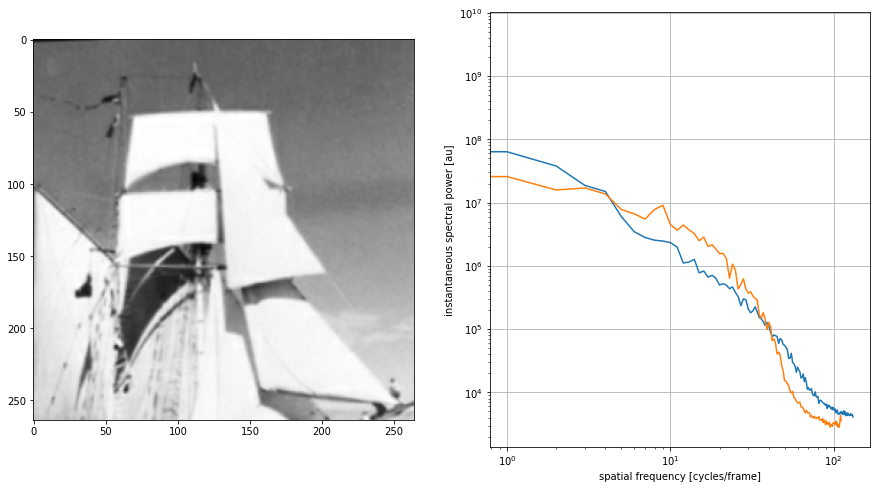

In [117]:
for i in range(config.batch_size):
    plt.figure(figsize=[15,8])
    plt.subplot(1,2,1)
    plt.imshow(env.images[i],cmap='gray')
    plt.subplot(1,2,2)
    _=plt.loglog(orig_spectrum[i])
    _=plt.loglog(retinal_spectrum[i])
    plt.grid()
    plt.xlabel('spatial frequency [cycles/frame]')
    plt.ylabel('instantaneous spectral power [au]')

# REDUCING THE AMPLITUDE BY A FACTOR OF TWO

In [125]:
this_game_name = 'amp1'

coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += np.random.randint(-1,2,(config.batch_size,2))
    env.step(origins_offset+coordinates)

orig_spectrum[this_game_name] = spectral_power_half(env.images)
retinal_spectrum[this_game_name] = spectral_power_half(env.retinal_view)

Text(0, 0.5, 'instantaneous spectral power [au]')

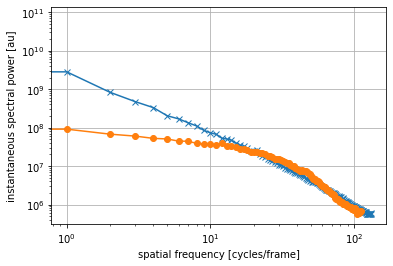

In [126]:
plt.loglog(orig_spectrum[this_game_name].sum(axis=0),'x-')
plt.loglog(retinal_spectrum[this_game_name].sum(axis=0),'o-')
plt.grid()
plt.xlabel('spatial frequency [cycles/frame]')
plt.ylabel('instantaneous spectral power [au]')

# IMPOSING GAUSSIAN MOTION

In [130]:
this_game_name = 'gaussian'
coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += np.random.normal(size=(config.batch_size,2))
    env.step(np.round(origins_offset+coordinates))

orig_spectrum[this_game_name] = spectral_power_half(env.images)
retinal_spectrum[this_game_name] = spectral_power_half(env.retinal_view)

Text(0, 0.5, 'instantaneous spectral power [au]')

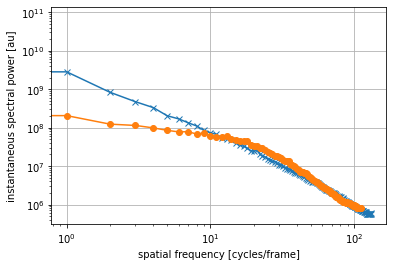

In [131]:
plt.loglog(orig_spectrum[this_game_name].sum(axis=0),'x-')
plt.loglog(retinal_spectrum[this_game_name].sum(axis=0),'o-')
plt.grid()
plt.xlabel('spatial frequency [cycles/frame]')
plt.ylabel('instantaneous spectral power [au]')

In [134]:
this_game_name = 'gaussian_x1p5'
coordinates = np.zeros((config.batch_size,2)) 
origins_offset = np.array([[config.image_hm//2,config.image_wm//2]])

for i in range(20):
    coordinates += 1.5*np.random.normal(size=(config.batch_size,2))
    env.step(np.round(origins_offset+coordinates))

orig_spectrum[this_game_name] = spectral_power_half(env.images)
retinal_spectrum[this_game_name] = spectral_power_half(env.retinal_view)

Text(0, 0.5, 'instantaneous spectral power [au]')

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/map_fn.py", line 497, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs)

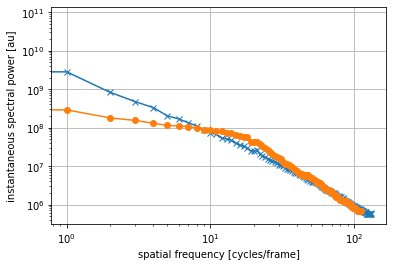

In [135]:
plt.loglog(orig_spectrum[this_game_name].sum(axis=0),'x-')
plt.loglog(retinal_spectrum[this_game_name].sum(axis=0),'o-')
plt.grid()
plt.xlabel('spatial frequency [cycles/frame]')
plt.ylabel('instantaneous spectral power [au]')

In [124]:
orig_spectrum = {}
retinal_spectrum = {}

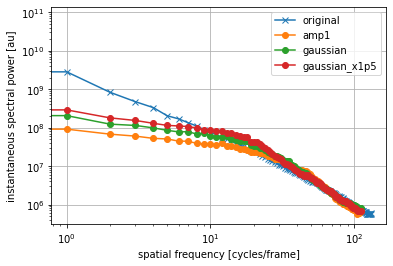

In [139]:
plt.loglog(orig_spectrum[this_game_name].sum(axis=0),'x-')
legend = ['original']
for this_game_name in retinal_spectrum:
    _=plt.loglog(retinal_spectrum[this_game_name].sum(axis=0),'o-')
    plt.grid()
    plt.xlabel('spatial frequency [cycles/frame]')
    plt.ylabel('instantaneous spectral power [au]')
    legend.append(this_game_name)
plt.legend(legend)